--- Escenario Base ---
Cuotas de Tarea (Base): {'Gamma_M': 0.25, 'Gamma_A': 0.25, 'Gamma_S': 0.25, 'Gamma_J': 0.25, 'Gamma_k': 0}
Output (y_base): 4.0000
Participación Capital (sK_base): 0.0000
Salarios (Base): w_M=1.0000, w_A=1.0000, w_S=1.0000, w_J=1.0000

--- Escenario Shock IA ---
Cuotas de Tarea (Shock): {'Gamma_M': 0.1, 'Gamma_A': 0.09999999999999998, 'Gamma_S': 0.25, 'Gamma_J': 0.25, 'Gamma_k': 0.30000000000000004}
Output (y_shock): 6.0686
Participación Capital (sK_shock): 0.3286
Salarios (Shock): w_M=0.7168, w_A=0.7168, w_S=1.3203, w_J=1.3203

--- Cambios Porcentuales (Shock vs Base) ---
Cambio en Output (y): 51.72%
Cambio en Participación Capital (sK): 32.86 puntos porcentuales
Cambio en Salario w_M: -28.32%
Cambio en Salario w_A: -28.32%
Cambio en Salario w_S: 32.03%
Cambio en Salario w_J: 32.03%


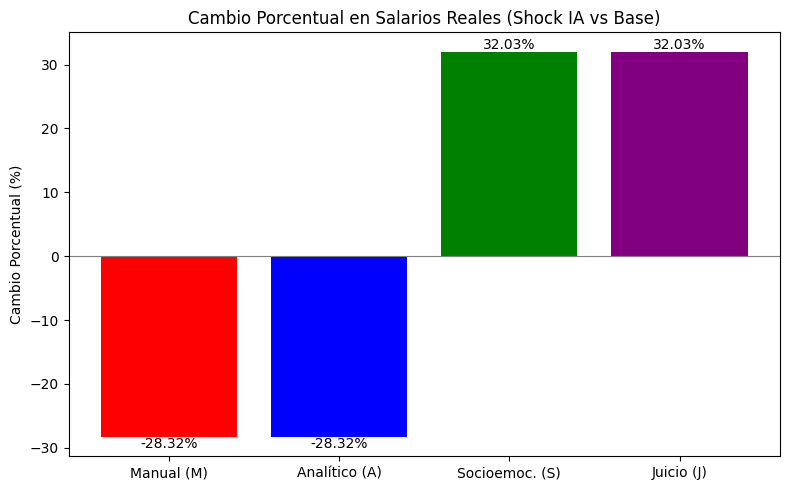

In [ ]:
# -*- coding: utf-8 -*-
"""
Modelo Simplificado de Tareas e IA (Límites Exógenos)

Prioriza estabilidad y facilidad de ejecución.
La asignación de tareas es FIJA por escenario (base vs shock),
no depende endógenamente de los salarios calculados.
"""

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------
# 1. PARÁMETROS DEL MODELO
# -------------------------------------
params = {
    # Elasticidad de sustitución entre tareas
    'lambda_': 1.5,  # Asegúrate que lambda > 1

    # Oferta total de trabajo (fija)
    'L_M': 1.0,  # Trabajadores Manuales/Rutinarios
    'L_A': 1.0,  # Trabajadores Analíticos
    'L_S': 1.0,  # Trabajadores Socioemocionales
    'L_J': 1.0,  # Trabajadores de Juicio

    # Productividad general de los factores (Augmenting factors)
    'A_M': 1.0,
    'A_A': 1.0,
    'A_S': 1.0,
    'A_J': 1.0,
    'A_k': 1.2,  # Productividad general de la IA/Capital

    # ----- Definición de las categorías de tareas -----
    # Asumimos un continuo de tareas x en [0, 1]
    'TR_range': (0.0, 0.25), # Tareas Rutinarias
    'TA_range': (0.25, 0.5), # Tareas Analíticas
    'TS_range': (0.5, 0.75), # Tareas Socioemocionales
    'TJ_range': (0.75, 1.0), # Tareas de Juicio

    # ----- Productividad específica (ψ) SIMPLIFICADA -----
    # Asumimos que cada tipo de trabajador es perfectamente productivo (ψ=1)
    # SOLO en su categoría principal y 0 en las demás.
    # Asumimos que IA tiene productividad ψ_k=1 donde opera (TR, TA) y 0 donde no (TS, TJ).
    # ¡Esta es una simplificación fuerte!
}

# -------------------------------------
# 2. DEFINICIÓN DE ESCENARIOS (Límites de Automatización)
# -------------------------------------

# Escenario BASE (poca o ninguna automatización)
# La IA realiza tareas TR desde 0 hasta este umbral:
threshold_TR_base = 0.0  # IA no hace tareas TR
# La IA realiza tareas TA desde 0.25 hasta este umbral:
threshold_TA_base = 0.25 # IA no hace tareas TA

# Escenario SHOCK (IA mejora y automatiza más)
# La IA ahora realiza tareas TR hasta este nuevo umbral:
threshold_TR_shock = 0.15 # IA automatiza el 15% inicial de tareas TR
# La IA ahora realiza tareas TA hasta este nuevo umbral:
threshold_TA_shock = 0.40 # IA automatiza desde el 25% hasta el 40% de tareas TA

# -------------------------------------
# 3. FUNCIÓN PARA CALCULAR CUOTAS DE TAREA (Γ) - DADO LOS LÍMITES
# -------------------------------------

def calculate_task_shares(threshold_TR, threshold_TA, params):
    """
    Calcula las cuotas de tarea Gamma para cada factor, DADOS los umbrales
    de automatización y asumiendo psi=1 en los rangos principales.
    Las Gammas aquí son simplemente la 'medida' (longitud) del intervalo de tareas
    realizado por cada factor.
    """
    TR_start, TR_end = params['TR_range']
    TA_start, TA_end = params['TA_range']
    TS_start, TS_end = params['TS_range']
    TJ_start, TJ_end = params['TJ_range']

    # Tareas asignadas a IA
    T_k_TR_len = max(0, threshold_TR - TR_start)
    T_k_TA_len = max(0, threshold_TA - TA_start)
    Gamma_k = T_k_TR_len + T_k_TA_len # Asumiendo A_k=1, q=1 para cálculo Gamma simple

    # Tareas asignadas a Trabajadores M (Rutinarios)
    T_M_len = max(0, TR_end - max(TR_start, threshold_TR))
    Gamma_M = T_M_len # Asumiendo A_M=1 para cálculo Gamma simple

    # Tareas asignadas a Trabajadores A (Analíticos)
    T_A_len = max(0, TA_end - max(TA_start, threshold_TA))
    Gamma_A = T_A_len # Asumiendo A_A=1 para cálculo Gamma simple

    # Tareas asignadas a Trabajadores S (Socioemocionales) - No automatizables
    T_S_len = max(0, TS_end - TS_start)
    Gamma_S = T_S_len # Asumiendo A_S=1 para cálculo Gamma simple

    # Tareas asignadas a Trabajadores J (Juicio) - No automatizables
    T_J_len = max(0, TJ_end - TJ_start)
    Gamma_J = T_J_len # Asumiendo A_J=1 para cálculo Gamma simple

    # Verificación (la suma de longitudes debe ser 1 si cubren todo el rango)
    total_len = T_k_TR_len + T_k_TA_len + T_M_len + T_A_len + T_S_len + T_J_len
    if not np.isclose(total_len, 1.0):
      print(f"¡Advertencia! La suma de longitudes de tareas asignadas es {total_len}, no 1.0")
      print(f"  T_k = {Gamma_k:.3f}, T_M = {Gamma_M:.3f}, T_A = {Gamma_A:.3f}, T_S = {Gamma_S:.3f}, T_J = {Gamma_J:.3f}")


    # Nota: Para ser estrictos con A&R, Gamma_g = ∫_{T_g} (A_g * ψ_g(x))^(λ-1) dx
    # y Gamma_k = ∫_{T_k} (A_k * ψ_k(x) * q(x))^(λ-1) dx.
    # Aquí, asumimos A_g=1, ψ_g=1 en T_g, A_k=1, ψ_k=1 en T_k, q=1,
    # por lo que Gamma es solo la longitud del intervalo.
    # Esto simplifica enormemente pero es menos general.

    return {'Gamma_M': Gamma_M, 'Gamma_A': Gamma_A, 'Gamma_S': Gamma_S, 'Gamma_J': Gamma_J, 'Gamma_k': Gamma_k}

# -------------------------------------
# 4. FUNCIÓN PARA RESOLVER EL EQUILIBRIO (CÁLCULO DIRECTO)
# -------------------------------------

def solve_equilibrium(Gammas, params):
    """
    Calcula el output, la participación del capital y los salarios
    directamente a partir de las cuotas de tarea (Gammas) fijas.
    Usa las fórmulas de A&R (2022) Proposición 1, adaptadas.
    """
    lambda_ = params['lambda_']
    L_M, L_A, L_S, L_J = params['L_M'], params['L_A'], params['L_S'], params['L_J']
    A_M, A_A, A_S, A_J, A_k = params['A_M'], params['A_A'], params['A_S'], params['A_J'], params['A_k']
    Gamma_M, Gamma_A, Gamma_S, Gamma_J, Gamma_k = Gammas['Gamma_M'], Gammas['Gamma_A'], Gammas['Gamma_S'], Gammas['Gamma_J'], Gammas['Gamma_k']

    if lambda_ == 1:
        raise ValueError("Lambda no puede ser 1 debido a la fórmula.")

    # Calcular Participación del Capital (s_K)
    # Aquí usamos la Gamma_k calculada asumiendo A_k=1, q=1.
    # Si A_k fuera diferente de 1, la Gamma_k debería incluirlo.
    s_K = (A_k**(lambda_ - 1)) * Gamma_k # Esta es P_k * Gamma_k en A&R notation if P_k = A_k^(lambda-1)

    # Calcular el término de suma ponderada de trabajo
    labor_term_sum = 0
    if L_M > 0 and Gamma_M > 0:
      labor_term_sum += (Gamma_M**(1/lambda_)) * ((A_M * L_M)**((lambda_ - 1)/lambda_))
    if L_A > 0 and Gamma_A > 0:
      labor_term_sum += (Gamma_A**(1/lambda_)) * ((A_A * L_A)**((lambda_ - 1)/lambda_))
    if L_S > 0 and Gamma_S > 0:
      labor_term_sum += (Gamma_S**(1/lambda_)) * ((A_S * L_S)**((lambda_ - 1)/lambda_))
    if L_J > 0 and Gamma_J > 0:
      labor_term_sum += (Gamma_J**(1/lambda_)) * ((A_J * L_J)**((lambda_ - 1)/lambda_))

    # Calcular Output (y)
    # Cuidado con 1 - s_K <= 0
    if s_K >= 1:
        print(f"Advertencia: s_K = {s_K:.3f} >= 1. El output podría ser infinito o indefinido.")
        y = np.inf
    elif labor_term_sum == 0:
         print(f"Advertencia: No hay contribución laboral positiva.")
         y = 0 # O podría ser interpretado de otra forma dependiendo del modelo exacto
    else:
        y = ((1 - s_K)**(lambda_ / (1 - lambda_))) * (labor_term_sum**(lambda_ / (lambda_ - 1)))


    # Calcular Salarios (w_g)
    w_M = 0
    if L_M > 0 and Gamma_M > 0:
        w_M = (y / L_M)**(1/lambda_) * (A_M**((lambda_ - 1)/lambda_)) * (Gamma_M**(1/lambda_))

    w_A = 0
    if L_A > 0 and Gamma_A > 0:
      w_A = (y / L_A)**(1/lambda_) * (A_A**((lambda_ - 1)/lambda_)) * (Gamma_A**(1/lambda_))

    w_S = 0
    if L_S > 0 and Gamma_S > 0:
      w_S = (y / L_S)**(1/lambda_) * (A_S**((lambda_ - 1)/lambda_)) * (Gamma_S**(1/lambda_))

    w_J = 0
    if L_J > 0 and Gamma_J > 0:
      w_J = (y / L_J)**(1/lambda_) * (A_J**((lambda_ - 1)/lambda_)) * (Gamma_J**(1/lambda_))

    results = {
        'y': y,
        's_K': s_K,
        'w_M': w_M,
        'w_A': w_A,
        'w_S': w_S,
        'w_J': w_J,
        'Gammas': Gammas # Guardamos las Gammas usadas
    }
    return results

# -------------------------------------
# 5. EJECUCIÓN Y COMPARACIÓN DE ESCENARIOS
# -------------------------------------

print("--- Escenario Base ---")
Gammas_base = calculate_task_shares(threshold_TR_base, threshold_TA_base, params)
print("Cuotas de Tarea (Base):", Gammas_base)
results_base = solve_equilibrium(Gammas_base, params)
print(f"Output (y_base): {results_base['y']:.4f}")
print(f"Participación Capital (sK_base): {results_base['s_K']:.4f}")
print(f"Salarios (Base): w_M={results_base['w_M']:.4f}, w_A={results_base['w_A']:.4f}, w_S={results_base['w_S']:.4f}, w_J={results_base['w_J']:.4f}")

print("\n--- Escenario Shock IA ---")
Gammas_shock = calculate_task_shares(threshold_TR_shock, threshold_TA_shock, params)
print("Cuotas de Tarea (Shock):", Gammas_shock)
results_shock = solve_equilibrium(Gammas_shock, params)
print(f"Output (y_shock): {results_shock['y']:.4f}")
print(f"Participación Capital (sK_shock): {results_shock['s_K']:.4f}")
print(f"Salarios (Shock): w_M={results_shock['w_M']:.4f}, w_A={results_shock['w_A']:.4f}, w_S={results_shock['w_S']:.4f}, w_J={results_shock['w_J']:.4f}")

print("\n--- Cambios Porcentuales (Shock vs Base) ---")

delta_y_pct = (results_shock['y'] / results_base['y'] - 1) * 100 if results_base['y'] != 0 else float('inf')
delta_sK = results_shock['s_K'] - results_base['s_K'] # Cambio absoluto en puntos porcentuales

# Cambios salariales (manejar división por cero si salario base es 0)
dw_M_pct = (results_shock['w_M'] / results_base['w_M'] - 1) * 100 if results_base['w_M'] > 0 else float('inf')
dw_A_pct = (results_shock['w_A'] / results_base['w_A'] - 1) * 100 if results_base['w_A'] > 0 else float('inf')
dw_S_pct = (results_shock['w_S'] / results_base['w_S'] - 1) * 100 if results_base['w_S'] > 0 else float('inf')
dw_J_pct = (results_shock['w_J'] / results_base['w_J'] - 1) * 100 if results_base['w_J'] > 0 else float('inf')

print(f"Cambio en Output (y): {delta_y_pct:.2f}%")
print(f"Cambio en Participación Capital (sK): {delta_sK*100:.2f} puntos porcentuales") # Mostrar como puntos
print(f"Cambio en Salario w_M: {dw_M_pct:.2f}%")
print(f"Cambio en Salario w_A: {dw_A_pct:.2f}%")
print(f"Cambio en Salario w_S: {dw_S_pct:.2f}%")
print(f"Cambio en Salario w_J: {dw_J_pct:.2f}%")

# -------------------------------------
# 6. VISUALIZACIÓN (Opcional)
# -------------------------------------

labels = ['Manual (M)', 'Analítico (A)', 'Socioemoc. (S)', 'Juicio (J)']
wage_changes = [dw_M_pct, dw_A_pct, dw_S_pct, dw_J_pct]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(labels, wage_changes, color=['red', 'blue', 'green', 'purple'])
ax.set_ylabel('Cambio Porcentual (%)')
ax.set_title('Cambio Porcentual en Salarios Reales (Shock IA vs Base)')
ax.axhline(0, color='gray', linewidth=0.8) # Línea en cero
ax.bar_label(bars, fmt='%.2f%%') # Añadir etiquetas a las barras

plt.tight_layout()
plt.show()

--- Iniciando Análisis de Estática Comparativa (Variando Lambda) ---
Calculando equilibrio para 20 valores de lambda...
Cálculos completados.

Generando gráficos...


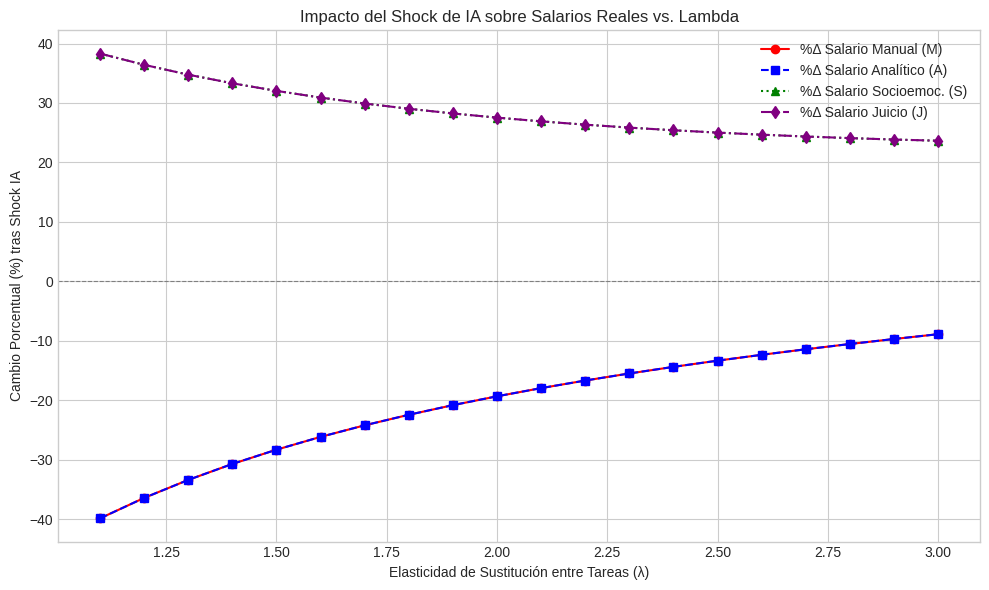

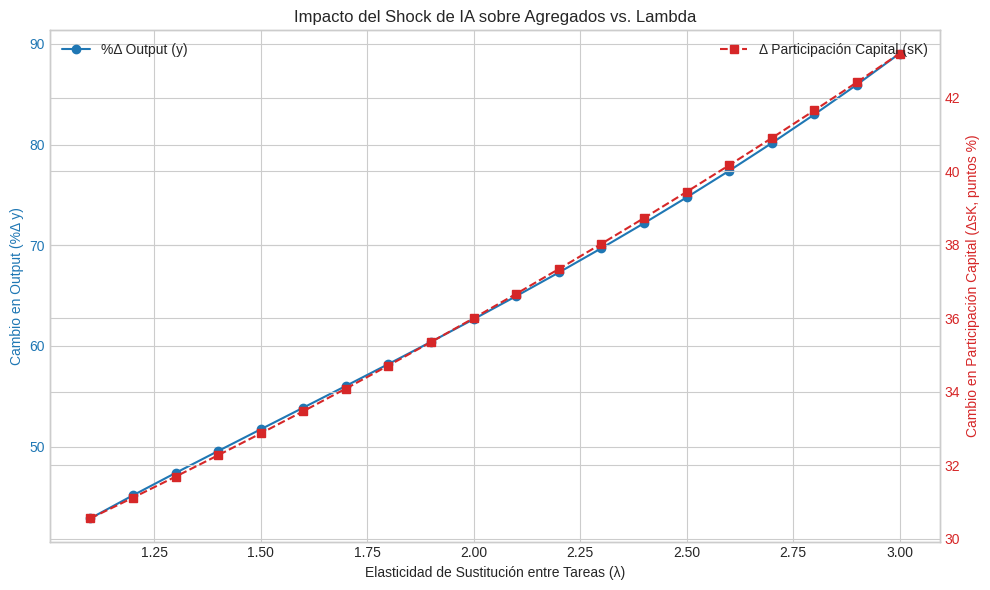


--- Análisis Completado ---


In [ ]:
# -*- coding: utf-8 -*-
"""
Estática Comparativa: Variando Lambda en el Modelo Simplificado

Analiza cómo la elasticidad de sustitución (lambda) afecta el impacto
de un shock tecnológico (definido por umbrales fijos) sobre los salarios y agregados.
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Usaremos pandas para manejar los resultados más fácilmente

print("--- Iniciando Análisis de Estática Comparativa (Variando Lambda) ---")

# -------------------------------------
# 1. PARÁMETROS FIJOS Y RANGO DE LAMBDA
# -------------------------------------

# Re-cargamos los parámetros base (por si se modificaron)
# Copia aquí los parámetros base si es necesario, o asegúrate que 'params' existe.
# Ejemplo:
params = {
    'lambda_': 1.5, # Este valor será SOBREESCRITO en el bucle
    'L_M': 1.0, 'L_A': 1.0, 'L_S': 1.0, 'L_J': 1.0,
    'A_M': 1.0, 'A_A': 1.0, 'A_S': 1.0, 'A_J': 1.0, 'A_k': 1.2,
    'TR_range': (0.0, 0.25), 'TA_range': (0.25, 0.5),
    'TS_range': (0.5, 0.75), 'TJ_range': (0.75, 1.0),
}

# Mantenemos FIJOS los umbrales del shock para este análisis
# (Queremos ver cómo lambda afecta el impacto de ESTE shock específico)
threshold_TR_base = 0.0
threshold_TA_base = 0.25
threshold_TR_shock = 0.15 # IA automatiza el 15% inicial de tareas TR
threshold_TA_shock = 0.40 # IA automatiza desde el 25% hasta el 40% de tareas TA

# Rango de valores para lambda a explorar
# Evitamos lambda=1 donde la fórmula tiene problemas
lambda_values = np.linspace(1.1, 3.0, 20) # 20 puntos entre 1.1 y 3.0

# Listas para almacenar los resultados de cada lambda
results_list = []

# -------------------------------------
# 2. BUCLE DE ESTÁTICA COMPARATIVA
# -------------------------------------

print(f"Calculando equilibrio para {len(lambda_values)} valores de lambda...")

for current_lambda in lambda_values:
    # Actualizar el valor de lambda en los parámetros para esta iteración
    params['lambda_'] = current_lambda

    # --- Resolver para el escenario BASE con el lambda actual ---
    Gammas_base = calculate_task_shares(threshold_TR_base, threshold_TA_base, params)
    try:
        results_base = solve_equilibrium(Gammas_base, params)
    except Exception as e:
        print(f"  Error resolviendo BASE para lambda={current_lambda:.2f}: {e}")
        continue # Saltar al siguiente lambda si hay error

    # --- Resolver para el escenario SHOCK con el lambda actual ---
    Gammas_shock = calculate_task_shares(threshold_TR_shock, threshold_TA_shock, params)
    try:
        results_shock = solve_equilibrium(Gammas_shock, params)
    except Exception as e:
        print(f"  Error resolviendo SHOCK para lambda={current_lambda:.2f}: {e}")
        continue # Saltar al siguiente lambda si hay error

    # --- Calcular cambios porcentuales y absolutos ---
    delta_y_pct = (results_shock['y'] / results_base['y'] - 1) * 100 if results_base['y'] > 0 else np.nan
    delta_sK = results_shock['s_K'] - results_base['s_K'] # Cambio absoluto

    dw_M_pct = (results_shock['w_M'] / results_base['w_M'] - 1) * 100 if results_base['w_M'] > 0 else np.nan
    dw_A_pct = (results_shock['w_A'] / results_base['w_A'] - 1) * 100 if results_base['w_A'] > 0 else np.nan
    dw_S_pct = (results_shock['w_S'] / results_base['w_S'] - 1) * 100 if results_base['w_S'] > 0 else np.nan
    dw_J_pct = (results_shock['w_J'] / results_base['w_J'] - 1) * 100 if results_base['w_J'] > 0 else np.nan

    # Guardar resultados de interés para este lambda
    results_list.append({
        'lambda': current_lambda,
        'y_base': results_base['y'],
        'w_M_base': results_base['w_M'],
        'w_A_base': results_base['w_A'],
        'w_S_base': results_base['w_S'],
        'w_J_base': results_base['w_J'],
        'sK_base': results_base['s_K'],
        'y_shock': results_shock['y'],
        'w_M_shock': results_shock['w_M'],
        'w_A_shock': results_shock['w_A'],
        'w_S_shock': results_shock['w_S'],
        'w_J_shock': results_shock['w_J'],
        'sK_shock': results_shock['s_K'],
        'delta_y_pct': delta_y_pct,
        'delta_sK_pts': delta_sK * 100, # Guardar como puntos porcentuales
        'dw_M_pct': dw_M_pct,
        'dw_A_pct': dw_A_pct,
        'dw_S_pct': dw_S_pct,
        'dw_J_pct': dw_J_pct
    })

print("Cálculos completados.")

# Convertir resultados a DataFrame de Pandas para fácil manejo
results_df = pd.DataFrame(results_list)

# Mostrar tabla de resultados (opcional)
# print("\n--- Tabla de Resultados de Estática Comparativa ---")
# print(results_df.to_string()) # Usar to_string para ver todas las columnas/filas

# -------------------------------------
# 3. VISUALIZACIÓN DE RESULTADOS
# -------------------------------------

print("\nGenerando gráficos...")

plt.style.use('seaborn-v0_8-whitegrid') # Estilo de gráfico

# --- Gráfico 1: Impacto del Shock en Salarios vs Lambda ---
fig1, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(results_df['lambda'], results_df['dw_M_pct'], marker='o', linestyle='-', label='%Δ Salario Manual (M)', color='red')
ax1.plot(results_df['lambda'], results_df['dw_A_pct'], marker='s', linestyle='--', label='%Δ Salario Analítico (A)', color='blue')
ax1.plot(results_df['lambda'], results_df['dw_S_pct'], marker='^', linestyle=':', label='%Δ Salario Socioemoc. (S)', color='green')
ax1.plot(results_df['lambda'], results_df['dw_J_pct'], marker='d', linestyle='-.', label='%Δ Salario Juicio (J)', color='purple')

ax1.set_xlabel('Elasticidad de Sustitución entre Tareas (λ)')
ax1.set_ylabel('Cambio Porcentual (%) tras Shock IA')
ax1.set_title('Impacto del Shock de IA sobre Salarios Reales vs. Lambda')
ax1.legend()
ax1.axhline(0, color='gray', linewidth=0.8, linestyle='--')
ax1.grid(True)

plt.tight_layout()
plt.show()

# --- Gráfico 2: Impacto del Shock en Agregados vs Lambda ---
fig2, ax2a = plt.subplots(figsize=(10, 6))

# Eje izquierdo para Output
color_y = 'tab:blue'
ax2a.set_xlabel('Elasticidad de Sustitución entre Tareas (λ)')
ax2a.set_ylabel('Cambio en Output (%Δ y)', color=color_y)
ax2a.plot(results_df['lambda'], results_df['delta_y_pct'], marker='o', linestyle='-', label='%Δ Output (y)', color=color_y)
ax2a.tick_params(axis='y', labelcolor=color_y)
ax2a.grid(True, axis='y')

# Eje derecho para Participación del Capital
ax2b = ax2a.twinx() # Instanciar un segundo eje que comparte el mismo eje x
color_sK = 'tab:red'
ax2b.set_ylabel('Cambio en Participación Capital (ΔsK, puntos %)', color=color_sK)
ax2b.plot(results_df['lambda'], results_df['delta_sK_pts'], marker='s', linestyle='--', label='Δ Participación Capital (sK)', color=color_sK)
ax2b.tick_params(axis='y', labelcolor=color_sK)

# Añadir leyenda combinada (opcional, puede ser complejo)
# fig2.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax2a.transAxes)
ax2a.legend(loc='upper left')
ax2b.legend(loc='upper right')


ax2a.set_title('Impacto del Shock de IA sobre Agregados vs. Lambda')
plt.tight_layout()
plt.show()

print("\n--- Análisis Completado ---")

In [ ]:
# -*- coding: utf-8 -*-
"""
PUNTO 6 (Framework): Targets Empíricos vía O*NET + OEWS (Versión CORREGIDA v5)

Este notebook calcula los targets de calibración (l_g, w_g/w_A, s_K)
cargando los archivos fuente de O*NET (4 archivos principales) y los datos
agregados de empleo y salarios de OEWS (1 archivo Excel nacional).
- v5: CORRIGE el error de formateo de OCC_CODE en OEWS.
"""

# 1. Imports
import pandas as pd
import numpy as np
import io
import warnings
import re
import os
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format) # Formato con 3 decimales

print("¡Librerías listas! ¡Vamos por esa calibración! (v5 - CORREGIDO)")

# --- CONFIGURACIÓN ---
# Revisa esta sección, especialmente onet_proxies

# 1. Año de los datos OEWS que usarás
OEWS_YEAR = 2023 # Corresponde a los datos de Mayo 2023

# 2. Selección DEFINITIVA de Proxies O*NET A,S,J,M
# (Puedes ajustar esta lista si consideras que faltan proxies importantes)
onet_proxies = {
    # Analítico (A)
    'A': ['1.A.1.b.4', '1.A.1.b.5', '1.A.1.c.1', '1.A.1.c.2', # Abilities: Deductive Reasoning, Inductive Reasoning, Mathematical Reasoning, Number Facility
          '2.B.1.a', #'2.B.2.b', '2.B.2.c', # Skills: Critical Thinking, (Systems Analysis, Systems Evaluation - OJO: Estos suelen dar problemas de datos en O*NET Skills.xlsx, por eso comentados)
          '2.B.3.a',                            # Skills: Complex Problem Solving
          '4.A.2.a.4', '4.A.3.b.1'],            # Work Activities: Analyzing Data, Working w Computers
    # Socioemocional (S)
    'S': ['1.A.1.a.3', '1.A.1.a.4',              # Abilities: Oral Expression, Written Expression
          '2.A.1.b', #'2.B.4.a', '2.B.4.b',       # Skills: Active Listening, (Social Perceptiveness, Coordination - OJO: Problemas de datos comunes)
          '2.B.4.c', '2.B.4.d', '2.B.4.e', #'2.B.4.f', # Skills: Persuasion, Negotiation, Instructing, (Service Orientation - OJO: Problemas de datos comunes)
          '4.A.4.a.2', '4.A.4.a.3', '4.A.4.a.4', '4.A.4.a.5', '4.A.4.a.7'], # Work Activities: Establishing Relationships, Assisting/Caring, Resolving Conflicts, Performing for Public, Communicating internally/externally (implícito)
    # Juicio (J)
    'J': ['1.A.1.b.1', '1.A.1.b.2', '1.A.1.b.3', # Abilities: Fluency of Ideas, Originality, Problem Sensitivity
          #'2.B.2.a',                             # Skills: Judgment and Decision Making (OJO: Problemas de datos comunes)
          '4.A.2.a.1', '4.A.2.b.1',             # Work Activities: Judging Qualities, Making Decisions
          #'4.C.3.a.1', # WC: Consequence of Error (OJO: Problemas de datos comunes)
          #'4.C.3.a.2', # WC: Impact of Decisions (OJO: Problemas de datos comunes)
          '4.C.3.a.4', '4.C.3.b.8'              # WC: Freedom to Make Decisions, Importance of Being Exact or Accurate
          ],
    # Manual/Rutinario (M)
    # Nota: Ampliando un poco más allá de solo repetitividad
    'M': ['1.A.3.a.2', '1.A.3.a.3',             # Abilities: Manual Dexterity, Finger Dexterity
          '4.A.3.a.2', '4.A.3.a.3',             # Work Activities: Handling Objects, Controlling Machines
          #'4.C.3.b.7'                           # Work Context: Importance of Repeating Same Tasks (OJO: Problemas de datos comunes)
          ]
}
# Nota: Se comentaron algunos proxies que a menudo faltan en los archivos O*NET o dan problemas.
# Puedes descomentarlos si verificas que tus archivos los contienen y quieres incluirlos.

# 3. Placeholder para Participación del Capital (¡Obtener de fuente externa!)
s_K_target_placeholder = 0.40 # <-- CAMBIA ESTO CON TU VALOR REAL para el OEWS_YEAR

# --- FIN CONFIGURACIÓN ---


# 2. Carga de Archivos Fuente (4 O*NET + 1 OEWS)
# ============================================================

# --- Helper Function for O*NET File Loading ---
def load_onet_file(uploaded_dict, expected_suffix, file_type_desc, require_data_cols=True):
    """Carga un archivo O*NET (txt o xlsx) desde el diccionario uploaded."""
    file_name = None; df = None
    found_files = [name for name in uploaded_dict.keys() if expected_suffix.lower() in name.lower()]
    if not found_files: print(f"ERROR: No se encontró archivo O*NET para '{file_type_desc}' (*{expected_suffix}*)."); return None
    if len(found_files) > 1:
        # Prioritize xlsx if multiple formats found
        xlsx_files = [f for f in found_files if f.lower().endswith('.xlsx')]
        if xlsx_files: file_name = xlsx_files[0]
        else: file_name = found_files[0] # Take the first one otherwise
        print(f"Advertencia: Múltiples archivos para {file_type_desc}. Usando: '{file_name}'")
    else: file_name = found_files[0]

    print(f"Cargando '{file_name}' ({file_type_desc})...")
    try:
        file_content = io.BytesIO(uploaded_dict[file_name])
        if file_name.lower().endswith('.txt'): df = pd.read_csv(file_content, delimiter='\t', encoding='utf-8', low_memory=False, on_bad_lines='warn'); print("  Archivo TXT leído.")
        elif file_name.lower().endswith('.xlsx'): df = pd.read_excel(file_content, header=0); print("  Archivo XLSX leído.")
        else: print(f"  Error: Formato no soportado para {file_name}"); return None

        # Clean column names immediately after loading
        df.columns = df.columns.str.strip().str.lower().str.replace('*', '', regex=False).str.replace('-', '_', regex=False).str.replace(' ', '_', regex=False)
        # Standardize O*NET SOC code column name
        if 'o_net_soc_code' in df.columns: df.rename(columns={'o_net_soc_code': 'onet_soc_code'}, inplace=True)
        if 'soc_code' in df.columns and 'onet_soc_code' not in df.columns: df.rename(columns={'soc_code': 'onet_soc_code'}, inplace=True) # Handle cases where it might be just 'soc_code'

        required_cols = ['onet_soc_code', 'element_id', 'scale_id', 'data_value']
        if require_data_cols:
            if not all(col in df.columns for col in required_cols): print(f"  ERROR CRÍTICO: Faltan columnas O*NET requeridas en {file_name}. Se necesitan: {required_cols}. Encontradas: {list(df.columns)}"); return None
            print(f"  Columnas limpiadas y verificadas (datos de índice).")
        else: # No require data cols (ej. if loading Occupation Data)
             if 'onet_soc_code' not in df.columns: print(f"  ERROR CRÍTICO: Falta 'onet_soc_code' en {file_name}."); return None
             print(f"  Columnas limpiadas y verificadas (archivo descriptivo).")
        return df
    except Exception as e: print(f"  Error al leer o procesar {file_name}: {e}"); return None

# --- Carga Principal ---
print(f"\n--- Paso 2: Carga de Archivos ---")
print("Por favor, sube los 5 archivos necesarios:")
print("  - Los 4 archivos O*NET principales (Abilities, Skills, Work Activities, Work Context) - preferiblemente .xlsx")
print(f"  - El archivo Excel (.xlsx) de OEWS Nacional para Mayo {OEWS_YEAR} (ej: national_M{OEWS_YEAR}_dl.xlsx).")
uploaded = files.upload()

# Cargar archivos O*NET
df_abilities = load_onet_file(uploaded, 'abilities', 'Abilities', require_data_cols=True)
df_skills = load_onet_file(uploaded, 'skills', 'Skills', require_data_cols=True)
df_work_activities = load_onet_file(uploaded, 'work_activities', 'Work Activities', require_data_cols=True)
df_work_context = load_onet_file(uploaded, 'work_context', 'Work Context', require_data_cols=True)

# Cargar archivo OEWS
df_oews = None; oews_file_name = None
# Try to find the specific national OEWS file for the year
oews_patterns = [f'national_m{OEWS_YEAR}_dl.xlsx', f'national_may{OEWS_YEAR}_dl.xlsx']
for name in uploaded.keys():
    if name.lower() in oews_patterns:
        oews_file_name = name
        break
# If not found, try a more generic pattern
if not oews_file_name:
    for name in uploaded.keys():
         if name.lower().endswith('.xlsx') and str(OEWS_YEAR) in name and 'national' in name.lower() and 'dl' in name.lower():
              oews_file_name = name
              break
# Last resort: any national excel that isn't O*NET
if not oews_file_name:
     for name in uploaded.keys():
          if name.lower().endswith('.xlsx') and 'national' in name.lower() and not any(onet_suffix in name.lower() for onet_suffix in ['abilities', 'skills', 'activities', 'context']):
               oews_file_name = name
               break

if not oews_file_name: print(f"ERROR CRÍTICO: No se pudo encontrar el archivo Excel de OEWS Nacional para {OEWS_YEAR}.")
else:
    print(f"Intentando cargar OEWS '{oews_file_name}'...")
    try:
        df_oews = pd.read_excel(io.BytesIO(uploaded[oews_file_name]), header=0)
        print(f"  Archivo OEWS '{oews_file_name}' leído.")
        # Clean OEWS columns immediately
        df_oews.columns = df_oews.columns.str.strip().str.upper()
        print(f"  Columnas OEWS limpiadas (disponibles): {df_oews.columns.tolist()}")
    except Exception as e: print(f"  Error al leer o procesar archivo OEWS: {e}\n  -> Verifica formato Excel."); df_oews = None

data_loaded_ok = all(df is not None for df in [df_abilities, df_skills, df_work_activities, df_work_context, df_oews])

# 3. Procesamiento O*NET: Cálculo de Índices A, S, J, M
# ============================================================
df_onet_indices = None
final_proxy_ids = [] # Initialize here
id_to_category = {} # Initialize here

if data_loaded_ok:
    print("\n--- Paso 3: Procesamiento O*NET y Cálculo de Índices ---")
    print("Usando los 4 archivos O*NET fuente.")

    all_proxy_ids = []; id_to_domain = {}; id_to_category = {}
    proxies_found_in_files = {cat: [] for cat in onet_proxies.keys()}
    proxies_not_found = {cat: [] for cat in onet_proxies.keys()}

    # Build the list of all unique proxy IDs needed
    for category, ids in onet_proxies.items():
        for element_id in ids:
            if element_id not in id_to_category:
                all_proxy_ids.append(element_id)
                # Determine domain based on prefix
                if element_id.startswith('1.'): domain = 'Abilities'
                elif element_id.startswith('2.'): domain = 'Skills'
                elif element_id.startswith('4.A'): domain = 'Work Activities'
                elif element_id.startswith('4.C'): domain = 'Work Context'
                else: domain = 'Unknown'
                id_to_domain[element_id] = domain
            id_to_category[element_id] = category # Map element_id to A, S, J, or M

    all_proxy_ids = sorted(list(set(all_proxy_ids)))
    print(f"Se buscarán {len(all_proxy_ids)} Element IDs únicos definidos en 'onet_proxies'.")

    onet_dfs = {'Abilities': df_abilities, 'Skills': df_skills,'Work Activities': df_work_activities, 'Work Context': df_work_context}
    relevant_onet_data = []; element_id_details = {}

    print("Filtrando datos O*NET por Element ID y Escala apropiada...")
    for element_id in all_proxy_ids:
        domain = id_to_domain.get(element_id)
        df_source = onet_dfs.get(domain)
        category = id_to_category.get(element_id)

        if df_source is not None and category is not None:
            # Determine the correct scale ID based on O*NET documentation/common practice
            if domain == 'Work Context':
                # Importance scale is often preferred for context, but check specific elements
                if element_id in ['4.C.3.b.7', '4.C.3.a.1', '4.C.3.b.8']: scale_id_to_use = 'IM' # Importance
                elif element_id in ['4.C.3.a.4']: scale_id_to_use = 'CX' # Context (Frequency/Duration)
                elif element_id in ['4.C.3.a.2']: scale_id_to_use = 'IM' # Impact of Decisions - Using IM for consistency
                else: scale_id_to_use = 'IM'; print(f"  Advertencia: Usando escala default '{scale_id_to_use}' para WC ID {element_id}")
            else: # Abilities, Skills, Work Activities usually use Level scale
                scale_id_to_use = 'LV'

            # Filter data for the specific element and scale
            filtered = df_source[(df_source['element_id'] == element_id) & (df_source['scale_id'].str.upper() == scale_id_to_use)]

            if not filtered.empty:
                # Store element details and the filtered data
                element_name = filtered['element_name'].iloc[0] if 'element_name' in filtered.columns else element_id
                element_id_details[element_id] = {'name': element_name, 'scale': scale_id_to_use, 'domain': domain}
                relevant_onet_data.append(filtered[['onet_soc_code', 'element_id', 'data_value']].copy())
                proxies_found_in_files[category].append(element_id)
                # print(f"  OK: Datos encontrados para ID {element_id} (Cat: {category}, Dom: {domain}, Scale: {scale_id_to_use})")
            else:
                # Record proxies that were not found
                print(f"  Advertencia: No se encontraron datos para ID {element_id} (Cat: {category}, Dom: {domain}) con escala '{scale_id_to_use}'. Proxy descartado.")
                proxies_not_found[category].append(element_id)
        else:
            # Record proxies where the domain DataFrame or category mapping was missing
             if category:
                 print(f"  Advertencia: No se encontró DataFrame para dominio '{domain}' del ID {element_id} (Cat: {category}). Proxy descartado.")
                 proxies_not_found[category].append(element_id)
             else:
                  print(f"  Advertencia: No se encontró mapeo de categoría para ID {element_id}. Proxy descartado.")


    # Update the list of actually used proxies
    final_proxy_ids = sorted(list(element_id_details.keys()))
    print(f"\nSe usarán {len(final_proxy_ids)} Element IDs con datos efectivamente encontrados.")
    for cat in onet_proxies.keys():
        num_found = len(proxies_found_in_files[cat])
        num_not_found = len(proxies_not_found[cat])
        print(f"  Categoría '{cat}': {num_found} proxies encontrados, {num_not_found} no encontrados/descartados.")
        if num_not_found > 0:
             print(f"     -> No encontrados/Descartados para '{cat}': {proxies_not_found[cat]}")


    if not relevant_onet_data or not final_proxy_ids:
        print("ERROR CRÍTICO: No se pudieron extraer datos O*NET para los proxies especificados.")
        data_loaded_ok = False
    else:
        df_onet_filtered = pd.concat(relevant_onet_data, ignore_index=True)
        print(f"Datos O*NET combinados/filtrados: {df_onet_filtered.shape[0]} filas.")

        # Convert data_value to numeric, coercing errors
        df_onet_filtered['data_value'] = pd.to_numeric(df_onet_filtered['data_value'], errors='coerce')

        # Drop rows with NaNs in essential columns (data_value or onet_soc_code)
        rows_before = len(df_onet_filtered)
        df_onet_filtered.dropna(subset=['data_value', 'onet_soc_code'], inplace=True)
        rows_after = len(df_onet_filtered)
        if rows_before > rows_after: print(f"  Eliminadas {rows_before - rows_after} filas O*NET con NaNs en data_value u onet_soc_code.")

        # Clean O*NET SOC codes (string, strip, remove .00)
        df_onet_filtered['onet_soc_code'] = df_onet_filtered['onet_soc_code'].astype(str).str.strip().str.replace(r'\.00$', '', regex=True)

        try:
            print("Pivotando datos O*NET por ocupación...");
            # Use pivot_table with mean aggregation to handle potential duplicate entries per occupation/element_id
            df_onet_pivot = df_onet_filtered.pivot_table(index='onet_soc_code', columns='element_id', values='data_value', aggfunc='mean')
            print(f"  O*NET pivotado: {df_onet_pivot.shape[0]} ocupaciones x {df_onet_pivot.shape[1]} proxies finales.")

            # Impute NaNs after pivot (using column mean)
            print("Rellenando NaNs post-pivot (usando media de la columna)...");
            cols_before_fillna = df_onet_pivot.columns.tolist()
            df_onet_pivot.fillna(df_onet_pivot.mean(), inplace=True)

            # Check if any columns are STILL all NaN after imputation (means the column had no data at all)
            cols_with_nan = df_onet_pivot.isnull().all()
            if cols_with_nan.any():
                cols_to_drop = cols_with_nan[cols_with_nan].index.tolist()
                print(f"  Advertencia: Eliminando {len(cols_to_drop)} columnas proxy que quedaron totalmente NaN: {cols_to_drop}")
                df_onet_pivot.drop(columns=cols_to_drop, inplace=True)
                # Update final_proxy_ids to reflect dropped columns
                final_proxy_ids = [pid for pid in final_proxy_ids if pid not in cols_to_drop]
                print(f"  Quedan {len(final_proxy_ids)} proxies finales efectivos.")

            if df_onet_pivot.empty or not final_proxy_ids:
                print("ERROR CRÍTICO: No quedaron datos O*NET válidos después del pivot/fillna.")
                data_loaded_ok = False
            else:
                print("Normalizando (Z-score) los valores de los proxies...");
                scaler = StandardScaler()
                # Apply scaler only to the final valid proxy columns
                df_onet_normalized = pd.DataFrame(scaler.fit_transform(df_onet_pivot[final_proxy_ids]),
                                                  index=df_onet_pivot.index, columns=final_proxy_ids)
                print("  Proxies normalizados (media=0, std=1 por columna).")

                print("Agregando proxies normalizados para crear índices A, S, J, M...")
                df_onet_indices = pd.DataFrame(index=df_onet_normalized.index)
                used_categories = []
                indices_created = []

                # Calculate index for each category (A, S, J, M)
                for category in ['A', 'S', 'J', 'M']:
                    # Get the final proxy IDs belonging to this category that are actually in the normalized df
                    category_cols = [pid for pid in final_proxy_ids
                                     if id_to_category.get(pid) == category and pid in df_onet_normalized.columns]

                    if category_cols:
                        # Calculate the mean of the normalized values for these proxies
                        df_onet_indices[f'{category}_index'] = df_onet_normalized[category_cols].mean(axis=1)
                        print(f"  Índice '{category}' creado (usando {len(category_cols)} proxies: {category_cols}).")
                        used_categories.append(category)
                        indices_created.append(f'{category}_index')
                    else:
                        print(f"  INFO: No hay proxies finales válidos para la categoría '{category}'. No se creará índice {category}.")
                        # Optionally create a column with a default value (e.g., NaN or a very low number)
                        # df_onet_indices[f'{category}_index'] = np.nan

                if not used_categories or not indices_created or df_onet_indices.empty:
                    print("ERROR CRÍTICO: No se pudo crear ningún índice A/S/J/M.")
                    df_onet_indices = None
                    data_loaded_ok = False
                else:
                    print(f"\nÍndices creados ({', '.join(indices_created)}):");
                    print(df_onet_indices.head())
                    print(f"\nResumen estadístico de los índices:")
                    print(df_onet_indices[indices_created].describe().round(3))

        except Exception as e:
            print(f"Error CRÍTICO durante el pivot/normalización/agregación de O*NET: {e}")
            traceback.print_exc() # Print detailed traceback
            df_onet_indices = None
            data_loaded_ok = False


# 4. Procesamiento Datos OEWS (REVISED v5)
# ============================================================
df_oews_processed = None
if data_loaded_ok:
    print("\n--- Paso 4: Procesamiento de Datos OEWS ---")
    oews_cols = {
        "area_type": "AREA_TYPE", "occ_code": "OCC_CODE", "occ_title": "OCC_TITLE",
        "o_group": "O_GROUP", "employment": "TOT_EMP", "annual_median": "A_MEDIAN",
        "annual_mean": "A_MEAN", "hourly_median": "H_MEDIAN", "hourly_mean": "H_MEAN"
    }
    missing_oews_cols = [std_name for std_name, oews_name in oews_cols.items() if oews_name not in df_oews.columns]
    if missing_oews_cols:
        print(f"ERROR CRÍTICO: Faltan columnas OEWS: {[oews_cols[key] for key in missing_oews_cols]}\nColumnas disponibles: {df_oews.columns.tolist()}")
        data_loaded_ok = False
    else:
        print("Columnas OEWS requeridas encontradas.")
        oews_rename_map = {v: k for k, v in oews_cols.items()}
        # Seleccionar solo las columnas necesarias desde el principio
        df_oews_subset = df_oews[list(oews_cols.values())].rename(columns=oews_rename_map)

        print("Filtrando OEWS por datos Nacionales y ocupaciones Detalladas...")
        df_oews_filtered = df_oews_subset[
            (df_oews_subset['area_type'] == 1) &
            (df_oews_subset['o_group'].astype(str).str.upper() == 'DETAILED') # Asegurar comparación como string
        ].copy()
        print(f"Filas OEWS después de filtrar por Nacional/Detallado: {len(df_oews_filtered)}")

        # --- REVISED SOC Code Handling ---
        print("Validando y limpiando código OCC_CODE (esperado XX-XXXX)...")
        if 'occ_code' not in df_oews_filtered.columns:
             print("ERROR CRÍTICO: Columna 'occ_code' no encontrada post-filtrado.")
             data_loaded_ok = False
        else:
            # Asegurar que es string y limpiar espacios blancos
            df_oews_filtered['occ_code'] = df_oews_filtered['occ_code'].astype(str).str.strip()

            # Validar el formato XX-XXXX (buena práctica)
            soc_format_valid = df_oews_filtered['occ_code'].str.match(r'^\d{2}-\d{4}$')
            invalid_soc_count = (~soc_format_valid).sum()

            if invalid_soc_count > 0:
                print(f"Advertencia: {invalid_soc_count} filas OEWS tienen 'occ_code' que NO coincide con el formato XX-XXXX. Se eliminarán.")
                # Descomentar para ver ejemplos inválidos si es necesario:
                # print("Ejemplos inválidos:")
                # print(df_oews_filtered[~soc_format_valid][['occ_code', 'occ_title']].head())
                df_oews_filtered = df_oews_filtered[soc_format_valid].copy() # Mantener solo los válidos

            # Renombrar a SOC_Code para consistencia (si quedan filas)
            if not df_oews_filtered.empty:
                df_oews_filtered.rename(columns={'occ_code': 'SOC_Code'}, inplace=True)
                print(f"Columna 'occ_code' validada y renombrada a 'SOC_Code'. Quedan {len(df_oews_filtered)} filas.")
            else:
                # Este caso ahora se maneja en el chequeo de abajo
                pass # print("Advertencia: Ninguna fila quedó después de validar el formato SOC_Code.")


            if df_oews_filtered.empty:
                print("ERROR CRÍTICO: No quedaron filas OEWS después de validar/filtrar SOC_Code.")
                data_loaded_ok = False
            else:
                print("Limpiando y convirtiendo columnas de Empleo y Salarios...")
                cols_to_clean = ['employment', 'annual_median', 'annual_mean', 'hourly_median', 'hourly_mean']
                for col in cols_to_clean:
                    if col in df_oews_filtered.columns:
                        # 1. Reemplazar símbolos específicos ('*', '**', '#') con NaN (Not a Number)
                        # ¡Importante usar regex=False para tratar '*' como literal!
                        df_oews_filtered[col] = df_oews_filtered[col].astype(str).replace(['*', '**', '#'], np.nan, regex=False)

                        # 2. Quitar comas (como separador de miles) si existen
                        # También usar regex=False para la coma literal
                        df_oews_filtered[col] = df_oews_filtered[col].astype(str).replace(',', '', regex=False)

                        # 3. Convertir a numérico.
                        # errors='coerce' transformará los np.nan introducidos y cualquier otro
                        # valor no numérico restante (como cadenas vacías si las hubiera) en NaN.
                        df_oews_filtered[col] = pd.to_numeric(df_oews_filtered[col], errors='coerce')

                print("  Columnas numéricas limpiadas y convertidas.")

                print("Seleccionando columna salarial anual...")
                df_oews_filtered['wage_final'] = np.nan
                wage_col_source = "Ninguna"
                wage_final_col = None # Resetear

                # Intentar usar A_MEDIAN si existe y tiene datos válidos
                if 'annual_median' in df_oews_filtered.columns and df_oews_filtered['annual_median'].notna().any():
                    wage_final_col = 'annual_median'
                    wage_col_source = 'Annual Median (A_MEDIAN)'
                # Si no, intentar con A_MEAN
                elif 'annual_mean' in df_oews_filtered.columns and df_oews_filtered['annual_mean'].notna().any():
                    wage_final_col = 'annual_mean'
                    wage_col_source = 'Annual Mean (A_MEAN)'
                # Si no, intentar con H_MEDIAN * 2080
                elif 'hourly_median' in df_oews_filtered.columns and df_oews_filtered['hourly_median'].notna().any():
                    wage_final_col = 'hourly_median'
                    wage_col_source = 'Hourly Median (H_MEDIAN * 2080)'
                    df_oews_filtered['wage_final'] = df_oews_filtered[wage_final_col] * 2080
                # Si no, intentar con H_MEAN * 2080
                elif 'hourly_mean' in df_oews_filtered.columns and df_oews_filtered['hourly_mean'].notna().any():
                    wage_final_col = 'hourly_mean'
                    wage_col_source = 'Hourly Mean (H_MEAN * 2080)'
                    df_oews_filtered['wage_final'] = df_oews_filtered[wage_final_col] * 2080

                # Si se usó A_MEDIAN o A_MEAN, copiar esos valores a wage_final
                if wage_final_col in ['annual_median', 'annual_mean']:
                    df_oews_filtered['wage_final'] = df_oews_filtered[wage_final_col]

                # Verificar si se encontró y procesó una columna salarial
                if wage_final_col is None or df_oews_filtered['wage_final'].isnull().all():
                    print("ERROR CRÍTICO: No se pudieron obtener datos salariales válidos de OEWS después de intentar todas las opciones.")
                    data_loaded_ok = False
                else:
                    print(f"Columna salarial final ('wage_final') creada usando: {wage_col_source}")
                    final_oews_cols = ['SOC_Code', 'occ_title', 'employment', 'wage_final']
                    # Asegurar que las columnas finales existen antes de seleccionar
                    final_oews_cols = [c for c in final_oews_cols if c in df_oews_filtered.columns]

                    if 'SOC_Code' not in final_oews_cols or 'employment' not in final_oews_cols or 'wage_final' not in final_oews_cols:
                        print(f"ERROR CRÍTICO: Columnas esenciales ({final_oews_cols}) no disponibles para selección final.")
                        data_loaded_ok = False
                    else:
                        # Eliminar NaNs en columnas clave ANTES de eliminar duplicados
                        df_oews_processed = df_oews_filtered[final_oews_cols].dropna(subset=['SOC_Code', 'employment', 'wage_final'])
                        # Asegurar que empleo sea positivo
                        df_oews_processed = df_oews_processed[df_oews_processed['employment'] > 0]
                        # Eliminar duplicados por SOC_Code, manteniendo la primera ocurrencia
                        df_oews_processed = df_oews_processed.drop_duplicates(subset=['SOC_Code'], keep='first').set_index('SOC_Code') # Set index here

                        print(f"Datos OEWS procesados listos para merge: {df_oews_processed.shape[0]} ocupaciones.")
                        print(df_oews_processed.head())


# 5. Merge Final: O*NET Índices + OEWS Procesado
# ============================================================
df_merged_final = None
if data_loaded_ok and df_onet_indices is not None and df_oews_processed is not None:
    print("\n--- Paso 5: Merge Final O*NET Índices + OEWS Datos ---")
    # Merge using the indices (onet_soc_code from O*NET and SOC_Code from OEWS)
    # Ensure both indices are strings for merging
    df_onet_indices.index = df_onet_indices.index.astype(str)
    df_oews_processed.index = df_oews_processed.index.astype(str)

    df_merged_final = pd.merge(
        df_onet_indices, df_oews_processed, left_index=True, right_index=True, how='inner'
    )
    print(f"Merge finalizado. Ocupaciones comunes en O*NET (con índices) y OEWS: {df_merged_final.shape[0]}")
    if df_merged_final.empty:
        print("ERROR CRÍTICO: El merge final no produjo resultados. Causas comunes:")
        print(" - Discrepancias en los formatos de los códigos SOC entre O*NET y OEWS a pesar de la limpieza.")
        print(" - Los archivos O*NET u OEWS cargados no corresponden al mismo sistema de codificación o año.")
        data_loaded_ok = False
    else:
        print("Primeras filas del DataFrame fusionado:")
        print(df_merged_final.head())
        # Check for NaNs introduced by merge (shouldn't happen with inner merge)
        if df_merged_final.isnull().any().any():
             print("Advertencia: Se encontraron NaNs después del merge. Revisar datos.")
             print(df_merged_final.isnull().sum())


# 6. Asignación de Tipo y Cálculo de Targets
# ============================================================
empirical_targets = None
if data_loaded_ok and df_merged_final is not None and not df_merged_final.empty:
    print("\n--- Paso 6: Asignación de Tipo y Cálculo de Targets Empíricos ---")

    index_cols = [col for col in df_merged_final.columns if col.endswith('_index')]
    if not index_cols:
        print("ERROR CRÍTICO: No se encontraron columnas de índice (_index) en el DataFrame fusionado.");
        data_loaded_ok = False
    else:
        print(f"Asignando tipo de trabajador (A, S, J, M) basado en el índice máximo entre: {index_cols}...")
        # Ensure all index columns exist, fill missing ones with -inf before idxmax
        available_indices = []
        for idx_col in ['A_index', 'S_index', 'J_index', 'M_index']:
            if idx_col in df_merged_final.columns:
                available_indices.append(idx_col)
            else:
                print(f"  INFO: Índice '{idx_col}' no fue creado (probablemente no había proxies válidos). Asignando -inf.")
                df_merged_final[idx_col] = -np.inf # Assign a very low value
        # Use only the available indices for comparison if not all were created
        cols_for_max = available_indices if len(available_indices)>0 else index_cols # Fallback

        if not cols_for_max:
             print("ERROR CRÍTICO: No hay columnas de índice disponibles para asignar tipo.")
             data_loaded_ok = False
        else:
             df_merged_final['worker_type'] = df_merged_final[cols_for_max].idxmax(axis=1).str.replace('_index', '')
             print("Distribución de tipos de trabajador asignados:");
             print(df_merged_final['worker_type'].value_counts(normalize=True).round(3))

             if not all(col in df_merged_final.columns for col in ['employment', 'wage_final', 'worker_type']):
                 print(f"ERROR CRÍTICO: Faltan columnas esenciales para calcular targets. Disponibles: {df_merged_final.columns.tolist()}");
                 data_loaded_ok = False
             else:
                # Clean data again just before aggregation (remove NaN/zero employment/wage)
                rows_before = len(df_merged_final)
                df_merged_final.dropna(subset=['employment', 'wage_final'], inplace=True)
                df_merged_final = df_merged_final[(df_merged_final['employment'] > 0) & (df_merged_final['wage_final'] > 0)] # Ensure wage is also positive
                if len(df_merged_final) < rows_before: print(f"  Se eliminaron {rows_before - len(df_merged_final)} ocupaciones con empleo o salario NaN/cero/negativo antes de agregar.")

                if len(df_merged_final) > 0 and df_merged_final['employment'].sum(skipna=True) > 0:
                    print(f"\nCalculando participación laboral (l_g) ponderada por empleo...")
                    labor_participation = df_merged_final.groupby('worker_type')['employment'].sum()
                    total_labor = labor_participation.sum()
                    if total_labor > 0:
                        l_g = (labor_participation / total_labor).round(4)
                        # Ensure all types A, S, J, M are present, fill with 0 if not
                        l_g = l_g.reindex(['A', 'S', 'J', 'M'], fill_value=0.0)
                        # Force sum to 1 (due to potential rounding)
                        l_g = l_g / l_g.sum()
                        print("  Participaciones laborales (l_g):"); print(l_g);
                    else: l_g = None; print("  Error: Empleo total cero o negativo.")

                    print(f"\nCalculando salarios por tipo (w_g) usando {wage_col_source} ponderado por empleo...")
                    # Weighted aggregation function (median or mean)
                    def weighted_agg(values, weights, agg_type='median'):
                        """ Calculates the weighted median or mean """
                        values = np.array(values)
                        weights = np.array(weights)
                        # Remove NaNs
                        not_nan_mask = ~np.isnan(values) & ~np.isnan(weights) & (weights > 0)
                        values = values[not_nan_mask]
                        weights = weights[not_nan_mask]
                        if len(values) == 0: return np.nan
                        try:
                            if agg_type == 'median':
                                i = np.argsort(values)
                                csw = np.cumsum(weights[i])
                                cutoff = csw[-1] / 2.0
                                median_idx = np.searchsorted(csw, cutoff, side='left')
                                return values[i[median_idx]]
                            elif agg_type == 'mean':
                                return np.average(values, weights=weights)
                            else: return np.nan
                        except Exception as e: print(f"Error in weighted_agg: {e}"); return np.nan

                    # Determine aggregation type based on source
                    agg_func_type = 'median' if 'median' in wage_col_source.lower() else 'mean'
                    print(f"  Usando agregación ponderada tipo: {agg_func_type}")

                    # Group by worker_type and apply weighted aggregation
                    grouped = df_merged_final.groupby('worker_type')
                    aggregated_wages = grouped.apply(lambda x: weighted_agg(x['wage_final'], x['employment'], agg_func_type), include_groups=False)

                    df_aggregated_wages = aggregated_wages.rename(f'{agg_func_type}_wage').reindex(['A', 'S', 'J', 'M'], fill_value=np.nan)
                    print(f"  {agg_func_type.capitalize()} salarial ponderado por tipo (w_g):"); print(df_aggregated_wages.round(2))

                    # Calculate relative wages w_g / w_A
                    if 'A' in df_aggregated_wages.index and pd.notna(df_aggregated_wages['A']) and df_aggregated_wages['A'] > 0:
                        w_A_agg = df_aggregated_wages['A']
                        relative_wages = (df_aggregated_wages / w_A_agg).round(3)
                        print("\n  Salarios relativos (w_g / w_A):"); print(relative_wages)
                    else:
                        relative_wages = None
                        print("  Error: Salario agregado w_A es inválido o cero. No se pueden calcular salarios relativos.")

                    print("\nTarget Participación del Capital (s_K):")
                    print(f"  Usando valor placeholder: s_K = {s_K_target_placeholder:.3f} (¡RECUERDA OBTENER VALOR REAL DE FUENTE EXTERNA!)")

                    # Compile final targets if all parts were successful
                    if l_g is not None and relative_wages is not None:
                        empirical_targets = {
                            'l_g': l_g.to_dict(),
                            'relative_wages': relative_wages.to_dict(),
                            f'absolute_{agg_func_type}_wages': df_aggregated_wages.round(2).to_dict(),
                            's_K': s_K_target_placeholder,
                            'N_common_occupations': len(df_merged_final),
                            'Total_employment_used': total_labor
                        }
                        print("\n" + "="*50);
                        print(f"--- RESUMEN: TARGETS EMPÍRICOS PARA CALIBRACIÓN ---");
                        print(f"--- (Año Base OEWS: {OEWS_YEAR}) ---");
                        print("="*50);
                        print("\n1. Participaciones Laborales (l_g):")
                        for g in ['A', 'S', 'J', 'M']: print(f"   l_{g} = {empirical_targets['l_g'].get(g, 0.0):.4f}")
                        print(f"   (Suma: {sum(empirical_targets['l_g'].values()):.4f})")

                        print("\n2. Salarios Relativos (w_g / w_A):");
                        for g in ['A', 'S', 'J', 'M']: print(f"   w_{g}/w_A = {empirical_targets['relative_wages'].get(g, np.nan):.3f}")

                        print(f"\n3. Participación del Capital (s_K): {empirical_targets['s_K']:.3f} (¡Placeholder!)")

                        print("\nInformación Adicional:")
                        print(f" - Salarios absolutos ({agg_func_type}) por tipo (w_g): ", empirical_targets[f'absolute_{agg_func_type}_wages'])
                        print(f" - Basado en {empirical_targets['N_common_occupations']} ocupaciones comunes O*NET-OEWS.")
                        print(f" - Empleo total considerado: {empirical_targets['Total_employment_used']:,.0f}")
                        print("="*50)
                    else:
                        empirical_targets = None
                        print("\nNo se pudieron calcular todos los targets finales (l_g o salarios relativos fallaron).")
                else:
                    empirical_targets = None
                    print("\nError: No hay datos válidos en el DataFrame fusionado para calcular targets (empleo total <= 0 o datos insuficientes).")
else:
    print("\n--- Pasos 5 y 6 OMITIDOS ---")
    if not data_loaded_ok: print("  Causa: Fallo en la carga o procesamiento inicial de datos (Pasos 2-4).")
    elif df_merged_final is None or df_merged_final.empty: print("  Causa: El merge entre O*NET y OEWS no produjo resultados (Paso 5).")
    else: print("  Causa: Desconocida (revisar logs).")


print("\n--- FIN DEL SCRIPT ---")
if 'empirical_targets' in locals() and empirical_targets is not None:
    print("\n¡Targets calculados! El diccionario 'empirical_targets' contiene los valores.")
    print("¡Mucha suerte con la calibración! ¡Qué emoción!")
else:
    print("\nNo se pudieron calcular los targets empíricos debido a errores previos.")
    print("Revisa los mensajes de ERROR CRÍTICO o Advertencia en los pasos anteriores.")

¡Librerías listas! ¡Vamos por esa calibración! (v5 - CORREGIDO)

--- Paso 2: Carga de Archivos ---
Por favor, sube los 5 archivos necesarios:
  - Los 4 archivos O*NET principales (Abilities, Skills, Work Activities, Work Context) - preferiblemente .xlsx
  - El archivo Excel (.xlsx) de OEWS Nacional para Mayo 2023 (ej: national_M2023_dl.xlsx).


Saving abilities.xlsx to abilities.xlsx
Saving national_M2023_dl.xlsx to national_M2023_dl.xlsx
Saving skills.xlsx to skills.xlsx
Saving work_activities.xlsx to work_activities.xlsx
Saving work_context.xlsx to work_context.xlsx
Cargando 'abilities.xlsx' (Abilities)...
  Archivo XLSX leído.
  Columnas limpiadas y verificadas (datos de índice).
Cargando 'skills.xlsx' (Skills)...
  Archivo XLSX leído.
  Columnas limpiadas y verificadas (datos de índice).
Cargando 'work_activities.xlsx' (Work Activities)...
  Archivo XLSX leído.
  Columnas limpiadas y verificadas (datos de índice).
Cargando 'work_context.xlsx' (Work Context)...
  Archivo XLSX leído.
  Columnas limpiadas y verificadas (datos de índice).
Intentando cargar OEWS 'national_M2023_dl.xlsx'...
  Archivo OEWS 'national_M2023_dl.xlsx' leído.
  Columnas OEWS limpiadas (disponibles): ['AREA', 'AREA_TITLE', 'AREA_TYPE', 'PRIM_STATE', 'NAICS', 'NAICS_TITLE', 'I_GROUP', 'OWN_CODE', 'OCC_CODE', 'OCC_TITLE', 'O_GROUP', 'TOT_EMP', 'EMP_PRSE

In [ ]:
# -*- coding: utf-8 -*-
"""
PUNTO 6 (Alternativa): Calibración Replicando s_K (Modelo Simplificado)

Encuentra los parámetros de productividad relativa (A_M, A_S, A_J)
para que el modelo simplificado (con Gammas exógenas)
replique los salarios relativos (w_g/w_A) Y la participación
del capital (s_K) empíricos en el estado base.

Esto se logra infiriendo un Gamma_k base > 0 a partir del target s_K
y asumiendo una distribución para los Gamma_g base restantes.
Mantiene la estabilidad computacional.
"""

import numpy as np
import pandas as pd
import warnings

# Silenciar warnings futuros o específicos si es necesario
# warnings.filterwarnings('ignore', category=FutureWarning)

print("--- Iniciando Calibración Alternativa (Replicando s_K) ---")

# -------------------------------------
# 1. TARGETS EMPÍRICOS (Resultados del Punto 6)
# -------------------------------------
# Asegúrate de que estos targets sean los correctos de tu ejecución anterior
# ¡ESPECIALMENTE s_K, que AHORA SÍ SE USARÁ!
empirical_targets = {
    'l_g': {'A': 0.1815, 'S': 0.2456, 'J': 0.0519, 'M': 0.5210},
    'relative_wages': {'A': 1.000, 'S': 0.752, 'J': 1.260, 'M': 0.477},
    's_K': 0.400 # ¡USA TU VALOR EMPÍRICO REAL AQUÍ SI LO TIENES!
}

print("Targets Empíricos a utilizar:")
print(" l_g:", empirical_targets['l_g'])
print(" w_g/w_A:", empirical_targets['relative_wages'])
print(f" s_K: {empirical_targets['s_K']}") # Ahora sí se usará

# -------------------------------------
# 2. PARÁMETROS FIJOS y NORMALIZACIÓN
# -------------------------------------

# Valor fijo para lambda (ajústalo si prefieres otro)
lambda_calib = 1.5
print(f"\nParámetros Fijos:")
print(f" - lambda = {lambda_calib}")

# Normalización: Fija la productividad de un tipo (usualmente A)
A_A_calib = 1.0
print(f" - A_A = {A_A_calib} (Normalización)")

# Fijar un valor para A_k (¡DEBE SER != 1 para que s_K dependa de lambda!)
A_k_calib = 1.2 # O el valor que prefieras, pero no 1.0
print(f" - A_k = {A_k_calib} (Fijado, debe ser != 1)")

# Usar las participaciones laborales como oferta de trabajo (L_g)
L_g_calib = empirical_targets['l_g']
print(f" - L_g = l_g empírico: {L_g_calib}")

# -------------------------------------
# 3. INFERIR/ASUMIR GAMMAS BASE a partir de s_K
# -------------------------------------
print("\nCalculando Gammas Base consistentes con target s_K...")
Gammas_base_calib = {}
calculation_possible_gamma = True

target_s_K = empirical_targets['s_K']

# Calcular Gamma_k_base_inferido = target_s_K / (A_k**(lambda - 1))
try:
    A_k_term = A_k_calib**(lambda_calib - 1)
    if A_k_term <= 0: # Evitar división por cero o negativo
         print("ERROR CRÍTICO: El término A_k**(lambda-1) es <= 0.")
         calculation_possible_gamma = False
    else:
        Gamma_k_base_inferido = target_s_K / A_k_term
        print(f" - Gamma_k Base Inferido = {target_s_K:.3f} / ({A_k_calib:.2f}^({lambda_calib:.1f}-1)) = {Gamma_k_base_inferido:.4f}")

        # Validar Gamma_k
        if not (0 <= Gamma_k_base_inferido < 1):
            print(f"ERROR CRÍTICO: Gamma_k Base Inferido ({Gamma_k_base_inferido:.4f}) está fuera del rango [0, 1). Revisa targets o parámetros fijos.")
            calculation_possible_gamma = False
        else:
            Gammas_base_calib['Gamma_k'] = Gamma_k_base_inferido

            # Calcular Gamma_L_base = 1 - Gamma_k_base_inferido
            Gamma_L_base = 1.0 - Gamma_k_base_inferido
            print(f" - Gamma Total Laboral Base = 1 - {Gamma_k_base_inferido:.4f} = {Gamma_L_base:.4f}")

            if Gamma_L_base < 0:
                 print("ERROR CRÍTICO: Gamma Total Laboral Base es negativo.")
                 calculation_possible_gamma = False
            else:
                # Distribuir Gamma_L_base entre tipos de trabajo proporcionalmente a l_g
                print(f" - Distribuyendo Gamma Laboral ({Gamma_L_base:.4f}) entre tipos según l_g...")
                sum_l_g = sum(L_g_calib.values()) # Debería ser 1, pero por si acaso
                if sum_l_g <= 0:
                    print("ERROR CRÍTICO: Suma de l_g es cero o negativa.")
                    calculation_possible_gamma = False
                else:
                    for g, l_g_val in L_g_calib.items():
                        Gamma_g_base = Gamma_L_base * (l_g_val / sum_l_g)
                        Gammas_base_calib[f'Gamma_{g}'] = Gamma_g_base
                        print(f"   - Gamma_{g}_base = {Gamma_L_base:.4f} * ({l_g_val:.4f} / {sum_l_g:.4f}) = {Gamma_g_base:.4f}")

                    # Verificación final de Gammas
                    sum_gammas_final = sum(Gammas_base_calib.values())
                    if not np.isclose(sum_gammas_final, 1.0):
                         print(f"ADVERTENCIA: La suma de todas las Gammas base calculadas ({sum_gammas_final:.4f}) no es 1.0.")
                    else:
                         print(" - Suma de Gammas base es 1.0. ¡Correcto!")

except Exception as e:
    print(f"ERROR calculando Gammas Base: {e}")
    calculation_possible_gamma = False

if not calculation_possible_gamma:
     print("No se pueden continuar los cálculos debido a errores en Gammas base.")

# -------------------------------------
# 4. CÁLCULO DIRECTO de A_M, A_S, A_J (Usando Nuevas Gammas Base)
# -------------------------------------
# Fórmula derivada: A_g = [ target_wg_rel * (L_g / L_A)**(1/λ) * (Gamma_A_base / Gamma_g_base)**(1/λ) ]**(λ / (λ - 1))

print("\nCalculando parámetros A_g relativos a A_A=1 (usando Gammas base inferidas)...")
calibrated_A = {'A': A_A_calib} # Iniciar con A_A normalizado
calculation_possible_A = calculation_possible_gamma # Continuar solo si Gammas ok

# Extraer L_A y Gamma_A_base para la fórmula
L_A_val = L_g_calib.get('A')
Gamma_A_base_val = Gammas_base_calib.get('Gamma_A')

if L_A_val is None or L_A_val <= 0 or Gamma_A_base_val is None or Gamma_A_base_val <= 0:
    print("ERROR CRÍTICO: L_A o Gamma_A_base no son válidos o son cero.")
    calculation_possible_A = False

if calculation_possible_A:
    lambda_term_exponent = lambda_calib / (lambda_calib - 1)

    for g in ['M', 'S', 'J']:
        target_wg_rel = empirical_targets['relative_wages'].get(g)
        L_g_val = L_g_calib.get(g)
        Gamma_g_base_val = Gammas_base_calib.get(f'Gamma_{g}')

        if target_wg_rel is None or L_g_val is None or L_g_val <= 0 or Gamma_g_base_val is None or Gamma_g_base_val <= 0:
            print(f"ERROR: Faltan datos válidos para calcular A_{g} (target={target_wg_rel}, L={L_g_val}, Gamma={Gamma_g_base_val})")
            calibrated_A[g] = np.nan # Marcar como no calculado
            continue

        try:
            # Calcular término ratio L: (L_g / L_A)**(1/λ)
            l_ratio_term = (L_g_val / L_A_val)**(1 / lambda_calib)

            # Calcular término ratio Gamma: (Gamma_A_base / Gamma_g_base)**(1/λ)
            gamma_ratio_term = (Gamma_A_base_val / Gamma_g_base_val)**(1 / lambda_calib)

            # Calcular término interior
            inner_term = target_wg_rel * l_ratio_term * gamma_ratio_term

            # Calcular A_g
            A_g_val = inner_term**lambda_term_exponent
            calibrated_A[g] = A_g_val
            print(f" - A_{g} calculado = {A_g_val:.4f}")

        except Exception as e:
            print(f"ERROR calculando A_{g}: {e}")
            calibrated_A[g] = np.nan
else:
     print("Cálculo de A_g omitido debido a errores previos.")

# -------------------------------------
# 5. RESULTADOS: PARÁMETROS CALIBRADOS
# -------------------------------------

print("\n--- PARÁMETROS CALIBRADOS (RESULTADO - ENFOQUE s_K) ---")
calibrated_params_sk = { # Usar un nombre diferente para el diccionario
    'lambda_': lambda_calib,
    'L_M': L_g_calib.get('M', 0.0),
    'L_A': L_g_calib.get('A', 0.0),
    'L_S': L_g_calib.get('S', 0.0),
    'L_J': L_g_calib.get('J', 0.0),
    'A_M': calibrated_A.get('M', np.nan),
    'A_A': calibrated_A.get('A', np.nan), # Should be 1.0
    'A_S': calibrated_A.get('S', np.nan),
    'A_J': calibrated_A.get('J', np.nan),
    'A_k': A_k_calib, # El valor fijado
    # Incluir rangos de tareas si son necesarios para otras partes
    'TR_range': (0.0, 0.25), 'TA_range': (0.25, 0.5),
    'TS_range': (0.5, 0.75), 'TJ_range': (0.75, 1.0),
}

# Chequear si todos los A_g se calcularon
params_complete_sk = calculation_possible_A and (not any(np.isnan(v) for k, v in calibrated_params_sk.items() if k.startswith('A_') and k != 'A_k'))

if params_complete_sk:
    print("Diccionario `calibrated_params_sk`:")
    # Imprimir de forma legible
    for key, value in calibrated_params_sk.items():
        if isinstance(value, float): print(f"  '{key}': {value:.4f}")
        else: print(f"  '{key}': {value}")
else:
    print("Diccionario `calibrated_params_sk` no se pudo completar debido a errores.")


# -------------------------------------
# 6. VERIFICACIÓN (Recomendado)
# -------------------------------------
# Usar los parámetros calibrados para resolver el modelo base y
# verificar si los salarios relativos Y s_K coinciden con los targets.

functions_exist = all(f in globals() for f in ['calculate_task_shares', 'solve_equilibrium'])

if functions_exist and params_complete_sk and calculation_possible_gamma:
    print("\n--- Verificación: Resolviendo modelo BASE con parámetros calibrados (Enfoque s_K) ---")

    # Usar los Gammas base INFERIDOS para la verificación
    verification_gammas = Gammas_base_calib
    print(f"Usando Gammas Base para verificación: {verification_gammas}")

    try:
        verification_results = solve_equilibrium(verification_gammas, calibrated_params_sk)

        # Calcular salarios relativos del modelo
        w_base_verif = verification_results
        model_rel_wages = {}
        if w_base_verif['w_A'] > 0:
            model_rel_wages['A'] = w_base_verif['w_A'] / w_base_verif['w_A']
            model_rel_wages['M'] = w_base_verif['w_M'] / w_base_verif['w_A']
            model_rel_wages['S'] = w_base_verif['w_S'] / w_base_verif['w_A']
            model_rel_wages['J'] = w_base_verif['w_J'] / w_base_verif['w_A']

            print("\nComparación Targets vs Modelo (Salarios Relativos w_g/w_A):")
            print("Tipo | Target Empírico | Modelo Calibrado | Diferencia")
            print("----|-----------------|------------------|-----------")
            for g in ['A', 'M', 'S', 'J']:
                target = empirical_targets['relative_wages'].get(g, np.nan)
                model_val = model_rel_wages.get(g, np.nan)
                diff = model_val - target if pd.notna(target) and pd.notna(model_val) else np.nan
                print(f" {g}  | {target:^15.3f} | {model_val:^16.3f} | {diff:^9.3g}")

            # Verificar s_K (AHORA DEBERÍA COINCIDIR)
            model_sK = verification_results['s_K']
            target_sK = empirical_targets['s_K']
            diff_sK = model_sK - target_sK
            print(f"\nComparación s_K:")
            print(f" - Target Empírico: {target_sK:.4f}")
            print(f" - Modelo Base Calibrado: {model_sK:.4f}")
            print(f" - Diferencia: {diff_sK:.3g} (¡Debería ser cercano a cero!)")

        else:
            print("Error en verificación: Salario w_A calculado es cero o inválido.")

    except Exception as e:
        print(f"Error durante la verificación: {e}")
else:
    print("\n--- Verificación OMITIDA ---")
    if not functions_exist: print("  Causa: Funciones 'calculate_task_shares' o 'solve_equilibrium' no definidas.")
    if not params_complete_sk: print("  Causa: No se pudieron calcular todos los parámetros A_g necesarios.")
    if not calculation_possible_gamma: print("  Causa: No se pudieron calcular las Gammas base.")


print("\n--- FIN DE LA CALIBRACIÓN ALTERNATIVA ---")
if params_complete_sk:
     print("\n¡Parámetros A_g calculados usando enfoque s_K! Revisa `calibrated_params_sk` y la verificación.")
else:
     print("\nLa calibración alternativa no pudo completarse debido a errores.")

--- Iniciando Calibración Alternativa (Replicando s_K) ---
Targets Empíricos a utilizar:
 l_g: {'A': 0.1815, 'S': 0.2456, 'J': 0.0519, 'M': 0.521}
 w_g/w_A: {'A': 1.0, 'S': 0.752, 'J': 1.26, 'M': 0.477}
 s_K: 0.4

Parámetros Fijos:
 - lambda = 1.5
 - A_A = 1.0 (Normalización)
 - A_k = 1.2 (Fijado, debe ser != 1)
 - L_g = l_g empírico: {'A': 0.1815, 'S': 0.2456, 'J': 0.0519, 'M': 0.521}

Calculando Gammas Base consistentes con target s_K...
 - Gamma_k Base Inferido = 0.400 / (1.20^(1.5-1)) = 0.3651
 - Gamma Total Laboral Base = 1 - 0.3651 = 0.6349
 - Distribuyendo Gamma Laboral (0.6349) entre tipos según l_g...
   - Gamma_A_base = 0.6349 * (0.1815 / 1.0000) = 0.1152
   - Gamma_S_base = 0.6349 * (0.2456 / 1.0000) = 0.1559
   - Gamma_J_base = 0.6349 * (0.0519 / 1.0000) = 0.0329
   - Gamma_M_base = 0.6349 * (0.5210 / 1.0000) = 0.3308
 - Suma de Gammas base es 1.0. ¡Correcto!

Calculando parámetros A_g relativos a A_A=1 (usando Gammas base inferidas)...
 - A_M calculado = 0.1085
 - A_S calc

In [ ]:
# -*- coding: utf-8 -*-
"""
PUNTO 7: Análisis Contrafactual con Modelo Calibrado

Utiliza el modelo simplificado estable, con los parámetros calibrados
del ENFOQUE 2 (que replica s_K), para analizar escenarios alternativos.

Escenarios Propuestos:
1. Shock IA Más Leve: Menor penetración de IA en tareas TR y TA.
2. Shock IA Más Severo: Mayor penetración de IA en tareas TR y TA.
3. Mejora Habilidades S (Política): Aumento exógeno en la productividad A_S.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy # Para copiar diccionarios de parámetros

# Silenciar warnings si es necesario
# import warnings
# warnings.filterwarnings('ignore', category=FutureWarning)

print("--- Iniciando Análisis Contrafactual (Punto 7) ---")

# -------------------------------------
# 1. Cargar Funciones y Parámetros Calibrados
# -------------------------------------

# >>>>>> VERIFICACIÓN DE FUNCIONES <<<<<<
# Asegúrate de que estas funciones estén definidas en tu sesión de Colab
# Ejemplo (simplificado, usa las tuyas completas):
# def calculate_task_shares(threshold_TR, threshold_TA, params): ...
# def solve_equilibrium(Gammas, params): ...

try:
    # Intenta llamar a las funciones con argumentos dummy para verificar existencia
    _ = calculate_task_shares(0, 0.25, {'lambda_': 1.5}) # Necesita params con lambda
    _ = solve_equilibrium({'Gamma_M':0.25, 'Gamma_A':0.25, 'Gamma_S':0.25, 'Gamma_J':0.25, 'Gamma_k':0},
                          {'lambda_': 1.5, 'L_M': 1, 'L_A': 1, 'L_S': 1, 'L_J': 1,
                           'A_M': 1, 'A_A': 1, 'A_S': 1, 'A_J': 1, 'A_k': 1})
    print("Funciones 'calculate_task_shares' y 'solve_equilibrium' encontradas.")
except NameError as e:
    print(f"ERROR CRÍTICO: Falta la función '{e.name}'.")
    print("              Asegúrate de ejecutar las celdas anteriores donde se definen.")
    # Detener ejecución si faltan funciones clave
    raise NameError(f"Función {e.name} no encontrada.")
except Exception as e:
    print(f"Error inesperado al verificar funciones: {e}")
    # Podrías querer detener la ejecución aquí también
    # raise e


# >>>>>> USA AQUÍ TUS PARÁMETROS CALIBRADOS DE LA OPCIÓN 2 <<<<<<
# Estos son los parámetros que SÍ replican s_K base
# Asegúrate que estos valores coincidan con los de tu ejecución anterior
calibrated_params_sk = {
    'lambda_': 1.5000,
    'L_M': 0.5210, 'L_A': 0.1815, 'L_S': 0.2456, 'L_J': 0.0519,
    'A_M': 0.1085, 'A_A': 1.0000, 'A_S': 0.4253, 'A_J': 2.0004,
    'A_k': 1.2000,
    'TR_range': (0.0, 0.25), 'TA_range': (0.25, 0.5),
    'TS_range': (0.5, 0.75), 'TJ_range': (0.75, 1.0),
}
print("\nUsando Parámetros Calibrados (Enfoque s_K):")
# Imprimir de forma legible
for key, value in calibrated_params_sk.items():
     if isinstance(value, float): print(f"  '{key}': {value:.4f}")
     else: print(f"  '{key}': {value}")


# >>>>>> USA AQUÍ TUS GAMMAS BASE INFERIDAS DE LA OPCIÓN 2 <<<<<<
# Estas son las Gammas consistentes con s_K=0.4 en la base
Gammas_base_calib = {
    'Gamma_k': 0.36514837167011077,
    'Gamma_A': 0.1152255705418749,
    'Gamma_S': 0.1559195599178208,
    'Gamma_J': 0.03294879951032126,
    'Gamma_M': 0.33075769835987234
}
# Asegurarse de que las llaves están bien
Gammas_base_calib = {f'Gamma_{k}' if not k.startswith('Gamma_') else k: v for k,v in Gammas_base_calib.items()}

print("\nUsando Gammas Base Inferidas (consistentes con s_K):")
for key, value in Gammas_base_calib.items():
     if isinstance(value, float): print(f"  '{key}': {value:.4f}")
     else: print(f"  '{key}': {value}")


# -------------------------------------
# 2. Calcular Equilibrio BASE (Calibrado)
# -------------------------------------
print("\nCalculando el equilibrio BASE con parámetros calibrados...")
try:
    # Recuperar targets para verificación (opcional pero útil)
    target_s_K = empirical_targets['s_K'] if 'empirical_targets' in locals() else 'N/A'
    results_base_calib = solve_equilibrium(Gammas_base_calib, calibrated_params_sk)
    print("Resultados Base Calibrado:")
    print(f"  Output (y_base): {results_base_calib['y']:.4f}")
    print(f"  s_K Base: {results_base_calib['s_K']:.4f} (Target: {target_s_K})") # Verificar s_K
    print(f"  Salarios Base: w_M={results_base_calib['w_M']:.4f}, w_A={results_base_calib['w_A']:.4f}, w_S={results_base_calib['w_S']:.4f}, w_J={results_base_calib['w_J']:.4f}")
except Exception as e:
    print(f"ERROR calculando el equilibrio base: {e}")
    results_base_calib = None # Indicar que falló


# -------------------------------------
# 3. Definir y Simular Escenarios Contrafactuales
# -------------------------------------

# Guardar resultados de los contrafactuales
cf_results = {}
scenario_details = {} # Para guardar detalles como thresholds o cambios A_S

if results_base_calib: # Proceder solo si la base se calculó bien
    y_base = results_base_calib['y'] # Output base para comparar

    # --- Escenario CF1: Shock IA Más Leve ---
    scenario_name_1 = 'Shock Leve IA'
    print(f"\n--- Escenario Contrafactual 1: {scenario_name_1} ---")
    threshold_TR_mild = 0.05 # IA solo toma el 5% de tareas TR
    threshold_TA_mild = 0.30 # IA solo llega hasta el 30% en TA
    scenario_details[scenario_name_1] = f"thr_TR={threshold_TR_mild}, thr_TA={threshold_TA_mild}"
    print(f"Asumiendo: {scenario_details[scenario_name_1]}")

    try:
        Gammas_cf1 = calculate_task_shares(threshold_TR_mild, threshold_TA_mild, calibrated_params_sk)
        results_cf1 = solve_equilibrium(Gammas_cf1, calibrated_params_sk)
        cf_results[scenario_name_1] = results_cf1
        print(f"Resultados {scenario_name_1}:")
        print(f"  Output (y_cf1): {results_cf1['y']:.4f} (%Δ vs Base: {(results_cf1['y']/y_base - 1)*100:.2f}%)")
        print(f"  s_K: {results_cf1['s_K']:.4f}")
        print(f"  Salarios: w_M={results_cf1['w_M']:.4f}, w_A={results_cf1['w_A']:.4f}, w_S={results_cf1['w_S']:.4f}, w_J={results_cf1['w_J']:.4f}")
    except Exception as e:
        print(f"ERROR calculando escenario '{scenario_name_1}': {e}")


    # --- Escenario CF2: Shock IA Más Severo ---
    scenario_name_2 = 'Shock Severo IA'
    print(f"\n--- Escenario Contrafactual 2: {scenario_name_2} ---")
    threshold_TR_harsh = 0.20 # IA toma el 20% de tareas TR
    threshold_TA_harsh = 0.45 # IA llega hasta el 45% en TA
    scenario_details[scenario_name_2] = f"thr_TR={threshold_TR_harsh}, thr_TA={threshold_TA_harsh}"
    print(f"Asumiendo: {scenario_details[scenario_name_2]}")

    try:
        Gammas_cf2 = calculate_task_shares(threshold_TR_harsh, threshold_TA_harsh, calibrated_params_sk)
        results_cf2 = solve_equilibrium(Gammas_cf2, calibrated_params_sk)
        cf_results[scenario_name_2] = results_cf2
        print(f"Resultados {scenario_name_2}:")
        print(f"  Output (y_cf2): {results_cf2['y']:.4f} (%Δ vs Base: {(results_cf2['y']/y_base - 1)*100:.2f}%)")
        print(f"  s_K: {results_cf2['s_K']:.4f}")
        print(f"  Salarios: w_M={results_cf2['w_M']:.4f}, w_A={results_cf2['w_A']:.4f}, w_S={results_cf2['w_S']:.4f}, w_J={results_cf2['w_J']:.4f}")
    except Exception as e:
        print(f"ERROR calculando escenario '{scenario_name_2}': {e}")


    # --- Escenario CF3: Mejora Habilidades S (Política de Entrenamiento) ---
    scenario_name_3 = 'Mejora A_S (+10%)'
    print(f"\n--- Escenario Contrafactual 3: {scenario_name_3} ---")
    # Creamos una copia de los parámetros calibrados para no modificarlos
    params_cf3 = copy.deepcopy(calibrated_params_sk)
    original_A_S = params_cf3['A_S']
    increase_factor = 1.10
    params_cf3['A_S'] = original_A_S * increase_factor
    scenario_details[scenario_name_3] = f"A_S: {original_A_S:.3f} -> {params_cf3['A_S']:.3f}"
    print(f"Asumiendo: {scenario_details[scenario_name_3]}")

    try:
        # ¡Este escenario se compara con la MISMA distribución de tareas BASE!
        # Solo cambia la productividad relativa de un tipo de trabajador.
        results_cf3 = solve_equilibrium(Gammas_base_calib, params_cf3) # Usar Gammas BASE y params MODIFICADOS
        cf_results[scenario_name_3] = results_cf3
        print(f"Resultados {scenario_name_3}:")
        print(f"  Output (y_cf3): {results_cf3['y']:.4f} (%Δ vs Base: {(results_cf3['y']/y_base - 1)*100:.2f}%)")
        # sK no debería cambiar si solo cambia A_S y Gamma_k es exógeno
        print(f"  s_K: {results_cf3['s_K']:.4f} (Esperado: {results_base_calib['s_K']:.4f})")
        print(f"  Salarios: w_M={results_cf3['w_M']:.4f}, w_A={results_cf3['w_A']:.4f}, w_S={results_cf3['w_S']:.4f}, w_J={results_cf3['w_J']:.4f}")
    except Exception as e:
        print(f"ERROR calculando escenario '{scenario_name_3}': {e}")


# -------------------------------------
# 4. Resumen Comparativo y Discusión
# -------------------------------------
print("\n" + "="*60)
print("--- Resumen del Análisis Contrafactual (Cambio % vs Base Calibrada) ---")
print("="*60)

summary_data = []
if results_base_calib:
    y_base = results_base_calib['y']
    w_base = {g: results_base_calib.get(f'w_{g}') for g in ['M', 'A', 'S', 'J']}
    sk_base = results_base_calib['s_K']

    # Añadir Base a la tabla para referencia
    summary_data.append({
        'Escenario': 'BASE (Calibrado)',
        '%Δ Output (y)': 0.0,
        '%Δ w_M': 0.0, '%Δ w_A': 0.0, '%Δ w_S': 0.0, '%Δ w_J': 0.0,
        's_K Final': sk_base,
        'Δs_K (pts)': 0.0,
        'Detalles': f"y={y_base:.2f}"
    })


    for name, results_cf in cf_results.items():
        delta_y_pct = (results_cf['y']/y_base - 1)*100 if y_base is not None and y_base > 0 else np.nan
        delta_w = {}
        for g in ['M', 'A', 'S', 'J']:
            w_cf = results_cf.get(f'w_{g}')
            w_b = w_base.get(g)
            delta_w[g] = (w_cf / w_b - 1)*100 if w_b is not None and w_b > 0 and w_cf is not None else np.nan

        sK_cf = results_cf.get('s_K', np.nan)
        delta_sK_pts = (sK_cf - sk_base)*100 if pd.notna(sK_cf) and pd.notna(sk_base) else np.nan

        summary_data.append({
            'Escenario': name,
            '%Δ Output (y)': delta_y_pct,
            '%Δ w_M': delta_w.get('M', np.nan),
            '%Δ w_A': delta_w.get('A', np.nan),
            '%Δ w_S': delta_w.get('S', np.nan),
            '%Δ w_J': delta_w.get('J', np.nan),
            's_K Final': sK_cf,
            'Δs_K (pts)': delta_sK_pts,
            'Detalles': scenario_details.get(name, '')
        })

    # Convertir a DataFrame para mostrar bonito
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False, float_format='{:,.2f}'.format))

else:
    print("No se pudo generar el resumen porque el cálculo base falló.")

print("\n" + "="*60)
print("--- Discusión (Punto 7) ---")
print("="*60)
print("""
**¿Cómo ayuda el modelo a entender las consecuencias?**

Este modelo calibrado (simplificado pero consistente con targets base) permite cuantificar
cómo diferentes escenarios afectan la economía a través de la reasignación de tareas
(aunque sea exógena en el shock) o cambios en la productividad relativa.

1.  **Impacto Diferencial del Alcance de la IA (CF1 vs CF2):**
    * El modelo muestra que un shock tecnológico de IA más *severo* (mayor penetración
        en tareas TR/TA, CF2) genera un **mayor aumento en el output agregado (y)**
        debido a mayores ganancias de eficiencia.
    * Sin embargo, este mayor crecimiento viene acompañado de una **mayor disrupción
        en el mercado laboral**: las caídas salariales para M y A son más profundas,
        mientras que las ganancias para S y J podrían ser mayores (o menores, dependiendo
        de lambda y los efectos de composición) en comparación con un shock más leve (CF1).
    * También ilustra cómo una mayor automatización lleva a una **mayor participación
        del capital (s_K)** en el ingreso total (el cambio Δs_K es mayor).
    * Permite cuantificar la magnitud de estos efectos *dados los parámetros calibrados*
        (lambda, A_g, L_g) que reflejan (aproximadamente) la estructura económica base.

2.  **Efecto de Políticas/Cambios en Habilidades (CF3):**
    * El modelo permite simular cómo un cambio en la productividad relativa de un
        grupo (ej. A_S sube por mejor educación/entrenamiento) impacta el equilibrio.
    * En el CF3, un aumento en A_S lleva a un **aumento en el output total (y)**,
        ya que la economía se vuelve más productiva en las tareas que realiza S.
    * También redistribuye ingresos: el salario `w_S` aumenta significativamente (tanto por mayor
        productividad directa como por efectos de equilibrio general), mientras que
        los salarios de otros grupos (M, A, J) también aumentan en este caso,
        probablemente porque el aumento general de `y` domina sobre los efectos
        de sustitución y porque `s_K` se mantiene constante en este escenario particular
        (ya que `Gamma_k` no cambió).
    * Ayuda a evaluar (cuantitativamente, dentro del modelo) el retorno agregado
        y distributivo de inversiones en capital humano específico.

**Limitaciones del Enfoque:**

* **Modelo Simplificado (Gammas Exógenas en Shock):** La limitación principal
    sigue siendo que el *alcance* de la automatización en los escenarios de shock IA
    (CF1, CF2) se impone exógenamente mediante los `thresholds`. El modelo no
    predice *endógenamente* cuánta IA se adoptará basándose en costos/salarios
    en respuesta al shock. Calcula las consecuencias *dado* un nivel de adopción.
* **Calibración Base:** Aunque la calibración (Opción 2) replica los targets,
    se basa en el supuesto de cómo se distribuían las tareas en la base para
    ser consistente con `s_K`. Los resultados cuantitativos dependen de este supuesto.
* **Parámetros Fijos:** Se asumieron valores fijos para `lambda` y `A_k` durante
    la calibración y simulación. Los resultados son sensibles a estos parámetros.
* **Estática Comparativa:** El análisis compara estados de equilibrio (base vs
    contrafactual) y no modela la dinámica de transición entre ellos.
* **Modelo Agregado:** Es un modelo de un solo sector, sin heterogeneidad
    dentro de los tipos de trabajadores ni fricciones en el mercado laboral.

**En conclusión:** El modelo, a pesar de sus simplificaciones (necesarias para
la estabilidad), proporciona un marco cuantitativo útil para realizar análisis
condicionales ("Si pasa X, entonces Y"), permitiendo explorar cómo shocks
tecnológicos o cambios en productividades relativas pueden impactar el
crecimiento agregado y la distribución del ingreso en una economía con tareas
y habilidades heterogéneas. Es crucial ser consciente de sus limitaciones al
interpretar los resultados numéricos.
""")

print("\n--- FIN DEL ANÁLISIS CONTRAFACTUAL ---")

--- Iniciando Análisis Contrafactual (Punto 7) ---
Error inesperado al verificar funciones: 'TR_range'

Usando Parámetros Calibrados (Enfoque s_K):
  'lambda_': 1.5000
  'L_M': 0.5210
  'L_A': 0.1815
  'L_S': 0.2456
  'L_J': 0.0519
  'A_M': 0.1085
  'A_A': 1.0000
  'A_S': 0.4253
  'A_J': 2.0004
  'A_k': 1.2000
  'TR_range': (0.0, 0.25)
  'TA_range': (0.25, 0.5)
  'TS_range': (0.5, 0.75)
  'TJ_range': (0.75, 1.0)

Usando Gammas Base Inferidas (consistentes con s_K):
  'Gamma_k': 0.3651
  'Gamma_A': 0.1152
  'Gamma_S': 0.1559
  'Gamma_J': 0.0329
  'Gamma_M': 0.3308

Calculando el equilibrio BASE con parámetros calibrados...
Resultados Base Calibrado:
  Output (y_base): 0.5869
  s_K Base: 0.4000 (Target: 0.4)
  Salarios Base: w_M=0.2470, w_A=0.5178, w_S=0.3894, w_J=0.6524

--- Escenario Contrafactual 1: Shock Leve IA ---
Asumiendo: thr_TR=0.05, thr_TA=0.3
Resultados Shock Leve IA:
  Output (y_cf1): 0.4823 (%Δ vs Base: -17.83%)
  s_K: 0.1095
  Salarios: w_M=0.1549, w_A=0.6561, w_S=0.4680, 